# MVP Comunidad Valenciana con Target Encoding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from tools import dataoveriew, plot_roc_curve, plot_confusion_matrix
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = None

%matplotlib inline

In [2]:
data = pd.read_excel('../data/portfolio_com_valencia.xlsx')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53


In [3]:
data.shape

(55225, 28)

In [4]:
data['Installation Number'] = data['Installation Number'].astype('str')
data['Zip'] = data['Zip'].astype('str')
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53


In [5]:
# Using Activo and Baja for 0 and 1    
class_names = ['Activo','Baja']

In [6]:
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53


## Feature engineering

- Edad en Años
- Rango de Income Amount
- Días Activo normalizado
- Normalizado de 'Quejas' y 'MT
- Normalizado de Latitud y Longitud ??

Rangos de Edad:

In [7]:
data.columns

Index(['Installation Date', 'Installation Number', 'Client Type', 'Panel',
       'Territorial', 'Provincia', 'Zip', 'Gender', 'Nationality',
       'Country Of Birth', 'Born Date', 'Housing Type', 'Labor Situation',
       'Marital Status', 'Income Amount', 'Number Pay', 'Price List',
       'Monitoring Status Date', 'Monitoring Status', 'Tipo Instalacion',
       'Financiado', 'Rango Kit', 'Resumen Precio', 'Kit Contado', 'Kit Total',
       'Kit Mensualidad', 'Quejas', 'MT'],
      dtype='object')

In [8]:
data['Born Date'].isnull().sum()

226

In [9]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53


In [10]:
data['Born Date'].isnull().sum()

0

In [11]:
# Edad actual si OP y edad cuando se dio de baja si BAJA

data['Edad'] = 0
fecha = datetime(2021, 1, 19)

for i in range(len(data['Born Date'])):
    if data.loc[i, 'Monitoring Status'] == 0:
        data.loc[i,'Edad'] = ((fecha - data.loc[i,'Born Date']).days)/365
    else:
        data.loc[i,'Edad'] = ((data.loc[i,'Monitoring Status Date'] - data.loc[i,'Born Date']).days)/365
                        
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096


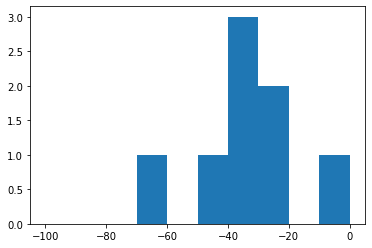

In [12]:
plt.hist(data['Edad'], range = (-100,0));

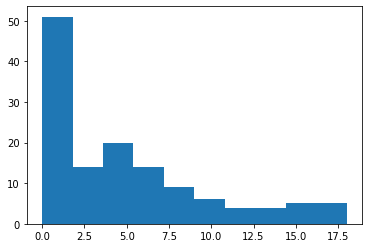

In [13]:
plt.hist(data['Edad'], range = (0,18));

In [14]:
data['Edad'].mean()

52.30091354793873

In [15]:
for i in range(len(data['Edad'])):
    if data.loc[i, 'Edad'] < 18:
        data.loc[i, 'Edad'] = data['Edad'].mean()
    else:
        continue

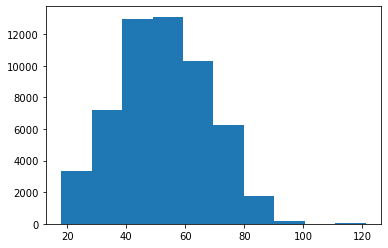

In [16]:
plt.hist(data['Edad']);

In [17]:
# Mapping Edad 
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad,Rango_Edad
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30


In [18]:
tab1 = pd.crosstab(data["Rango_Edad"], data["Monitoring Status"], margins = True)
tab2 = pd.crosstab(data["Rango_Edad"], data["Monitoring Status"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Monitoring Status,0,1,All,0,1
Rango_Edad,,,,,
+80,1602,319,1921,0.833941,0.166059
18-30,2516,1582,4098,0.613958,0.386042
30-40,4622,3306,7928,0.582997,0.417003
40-50,8794,4082,12876,0.682976,0.317024
50-60,9820,2747,12567,0.781412,0.218588
60-70,8379,1489,9868,0.849108,0.150892
70-80,5202,765,5967,0.871795,0.128205
All,40935,14290,55225,0.741240,0.258760


Rangos de Income Amount:

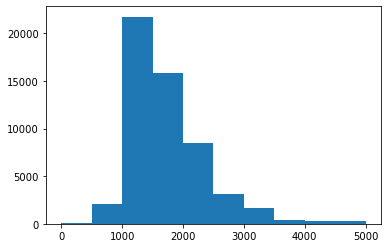

In [19]:
plt.hist(data['Income Amount'], range=(0, 5000));

In [20]:
# Mapping Income Amount
data.loc[data['Income Amount'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Income Amount'] > 1000) & (data['Income Amount'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Income Amount'] > 1500) & (data['Income Amount'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Income Amount'] > 2000) & (data['Income Amount'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Income Amount'] > 3000, 'Income'] = "+3000"
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad,Rango_Edad,Income
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000


In [21]:
tab1 = pd.crosstab(data["Income"], data["Monitoring Status"], margins = True)
tab2 = pd.crosstab(data["Income"], data["Monitoring Status"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Monitoring Status,0,1,All,0,1
Income,,,,,
+3000,1687,448,2135,0.790164,0.209836
0-1000,6979,3147,10126,0.689216,0.310784
1000-1500,18435,6408,24843,0.742060,0.257940
1500-2000,9482,3084,12566,0.754576,0.245424
2000-3000,4352,1203,5555,0.783438,0.216562
All,40935,14290,55225,0.741240,0.258760


Días Activo:

In [22]:
# Días hasta el 19/01/2021 si OP y hasta cuando se dio de baja si BAJA

data['Dias_Activo'] = 0
fecha = datetime(2021, 1, 19)

for i in range(len(data['Installation Date'])):
    if data.loc[i, 'Monitoring Status'] == 0:
        data.loc[i,'Dias_Activo'] = (fecha - data.loc[i,'Installation Date']).days
    else:
        data.loc[i,'Dias_Activo'] = (data.loc[i,'Monitoring Status Date'] - data.loc[i,'Installation Date']).days
                        
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad,Rango_Edad,Income,Dias_Activo
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000,987
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500,1093
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000,1150
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500,2206
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000,1165


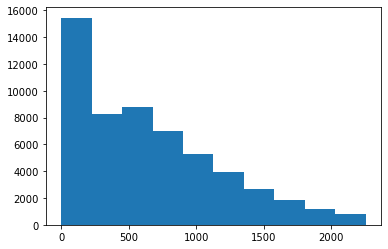

In [23]:
plt.hist(data['Dias_Activo']);

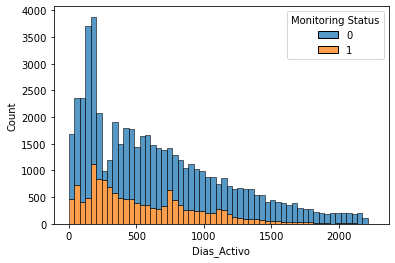

In [24]:
sns.histplot(data = data, x = 'Dias_Activo', hue = 'Monitoring Status', multiple = 'stack')

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['Dias_Activo_sca'] = scaler.fit_transform(data['Dias_Activo'].values.reshape(-1, 1))
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000,987,0.437694
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500,1093,0.484701
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000,1150,0.509978
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500,2206,0.978271
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000,1165,0.516630


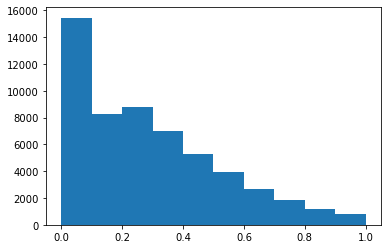

In [26]:
plt.hist(data['Dias_Activo_sca']);

Normalizado de Quejas y Missing Test (MT):

In [27]:
scaler = MinMaxScaler()
data['Quejas_sca'] = scaler.fit_transform(data['Quejas'].values.reshape(-1, 1))
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000,987,0.437694,0.035714
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500,1093,0.484701,0.000000
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000,1150,0.509978,0.035714
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500,2206,0.978271,0.035714
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000,1165,0.516630,0.000000


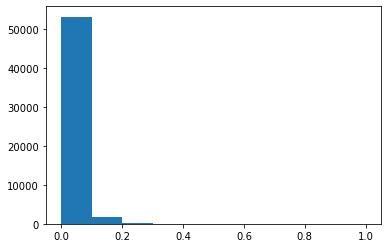

In [28]:
plt.hist(data['Quejas_sca']);

In [29]:
scaler = MinMaxScaler()
data['MT_sca'] = scaler.fit_transform(data['MT'].values.reshape(-1, 1))
data.head()

,Installation Date,Installation Number,Client Type,Panel,Territorial,Provincia,Zip,Gender,Nationality,Country Of Birth,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Price List,Monitoring Status Date,Monitoring Status,Tipo Instalacion,Financiado,Rango Kit,Resumen Precio,Kit Contado,Kit Total,Kit Mensualidad,Quejas,MT,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca,MT_sca
0,2015-01-02,1833185,Normal,SDVFAST,Este,Alicante,3300,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1973-05-19,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,2500,14,HBD,2017-09-15,1,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.356164,40-50,2000-3000,987,0.437694,0.035714,0.000000
1,2015-01-03,1833306,Normal,SDVFAST,Este,Alicante,3689,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-05-08,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1200,14,HBD,2017-12-31,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,0,41.676712,40-50,1000-1500,1093,0.484701,0.000000,0.000000
2,2015-01-05,1833404,Normal,SDVFAST,Este,Valencia,46117,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1982-03-15,1 - PROPIEDAD SIN HIPOTECA,02 ASALARIADO TEMPORAL,1 - SOLTERO,800,14,EED,2018-02-28,1,"P-Chalet, villa (domicilio particular)",Financiado,Entre 000-050,49+(36*10),49,409,10,1,0,35.983562,30-40,0-1000,1150,0.509978,0.035714,0.000000
3,2015-01-05,1833511,Normal,SDVFAST,Este,Alicante,3150,H - HOMBRE,ES - ESPAÑOLA,SPAIN,1976-02-02,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1500,12,HBD,2015-01-07,0,"P-Chalet, villa (domicilio particular)",Financiado,A 0,0+(36*10),0,360,10,1,0,44.994521,40-50,1000-1500,2206,0.978271,0.035714,0.000000
4,2015-01-05,1833532,Normal,SDVFAST,Este,Alicante,3294,M - MUJER,ES - ESPAÑOLA,SPAIN,1989-07-31,1 - PROPIEDAD SIN HIPOTECA,06 PARADO,1 - SOLTERO,1000,12,HBD,2018-03-15,1,P-Apartamento (domicilio particular),Financiado,A 0,0+(36*10),0,360,10,0,53,28.641096,18-30,0-1000,1165,0.516630,0.000000,0.194853


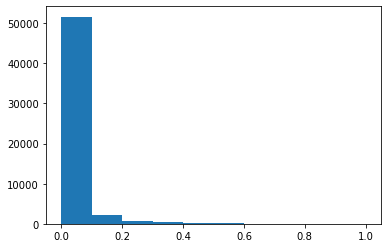

In [30]:
plt.hist(data['MT_sca']);

## Enconding con ``target encoding``

In [31]:
data.columns

Index(['Installation Date', 'Installation Number', 'Client Type', 'Panel',
       'Territorial', 'Provincia', 'Zip', 'Gender', 'Nationality',
       'Country Of Birth', 'Born Date', 'Housing Type', 'Labor Situation',
       'Marital Status', 'Income Amount', 'Number Pay', 'Price List',
       'Monitoring Status Date', 'Monitoring Status', 'Tipo Instalacion',
       'Financiado', 'Rango Kit', 'Resumen Precio', 'Kit Contado', 'Kit Total',
       'Kit Mensualidad', 'Quejas', 'MT', 'Edad', 'Rango_Edad', 'Income',
       'Dias_Activo', 'Dias_Activo_sca', 'Quejas_sca', 'MT_sca'],
      dtype='object')

In [32]:
data_filtered = data[['Gender', 'Housing Type', 'Tipo Instalacion', 'Labor Situation', 'Marital Status', 'Zip',
                      'Provincia', 'Nationality', 'Rango_Edad', 'Income', 'Rango Kit', 'Number Pay', 'Dias_Activo_sca',
                      'Quejas_sca', 'MT_sca', 'Monitoring Status']]
data_filtered.columns

Index(['Gender', 'Housing Type', 'Tipo Instalacion', 'Labor Situation',
       'Marital Status', 'Zip', 'Provincia', 'Nationality', 'Rango_Edad',
       'Income', 'Rango Kit', 'Number Pay', 'Dias_Activo_sca', 'Quejas_sca',
       'MT_sca', 'Monitoring Status'],
      dtype='object')

In [33]:
X = data_filtered.drop(['Monitoring Status'],axis=1)
y = data_filtered['Monitoring Status']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [35]:
features_TE = ['Gender', 'Housing Type', 'Tipo Instalacion', 'Labor Situation', 'Marital Status', 'Zip',
                      'Provincia', 'Nationality', 'Rango_Edad', 'Income', 'Rango Kit', 'Number Pay']

In [36]:
from category_encoders import TargetEncoder

TE_encoder = TargetEncoder(cols=features_TE)

In [37]:
TE_encoder.fit(X_train, y_train)
X_train = TE_encoder.transform(X_train)
X_train.head()

C:\Users\alber\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Gender,Housing Type,Tipo Instalacion,Labor Situation,Marital Status,Zip,Provincia,Nationality,Rango_Edad,Income,Rango Kit,Number Pay,Dias_Activo_sca,Quejas_sca,MT_sca
33401,0.276589,0.229933,0.211469,0.221639,0.218265,0.164751,0.219859,0.257225,0.127708,0.257014,0.307197,0.284631,0.253659,0.071429,0.503676
28602,0.254037,0.229933,0.207563,0.144030,0.218265,0.256610,0.219859,0.248352,0.150680,0.310933,0.137880,0.284631,0.310421,0.000000,0.000000
38502,0.254037,0.229933,0.207563,0.221639,0.218265,0.176136,0.219859,0.248352,0.216662,0.245700,0.329687,0.231701,0.178714,0.000000,0.000000
43040,0.254037,0.229933,0.211469,0.144030,0.218265,0.335404,0.219859,0.257225,0.168635,0.257014,0.237612,0.284631,0.102882,0.000000,0.000000
10410,0.254037,0.229933,0.211469,0.144030,0.182944,0.272374,0.219859,0.257225,0.127708,0.257014,0.137880,0.284631,0.619512,0.000000,0.003676


In [38]:
X_test = TE_encoder.transform(X_test)
X_test.head()

,Gender,Housing Type,Tipo Instalacion,Labor Situation,Marital Status,Zip,Provincia,Nationality,Rango_Edad,Income,Rango Kit,Number Pay,Dias_Activo_sca,Quejas_sca,MT_sca
51294,0.254037,0.229933,0.211469,0.144030,0.182944,0.114650,0.273009,0.257225,0.127708,0.257014,0.237612,0.231701,0.046563,0.000000,0.000000
25822,0.276589,0.229933,0.207563,0.221639,0.373304,0.285024,0.345411,0.257225,0.150680,0.310933,0.237612,0.284631,0.354324,0.035714,0.007353
20706,0.254037,0.229933,0.211469,0.144030,0.182944,0.222222,0.219859,0.248352,0.127708,0.310933,0.137880,0.284631,0.431042,0.000000,0.000000
23232,0.254037,0.229933,0.207563,0.144030,0.218265,0.313953,0.345411,0.257225,0.150680,0.257014,0.329687,0.284631,0.388027,0.035714,0.003676
24115,0.276589,0.229933,0.211469,0.221639,0.373304,0.388235,0.219859,0.257225,0.317454,0.310933,0.237612,0.231701,0.379601,0.000000,0.000000


### Regresión Logística

Logistic Accuracy is 0.74
Cross Validation Score = 0.74
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      8187
           1       0.50      0.71      0.59      2858

    accuracy                           0.74     11045
   macro avg       0.69      0.73      0.70     11045
weighted avg       0.78      0.74      0.75     11045



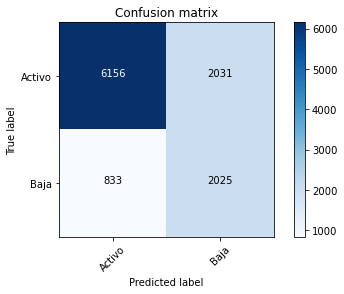

In [39]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state = 0, max_iter=1000, class_weight="balanced")
LR.fit(X_train,y_train) 
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_test, LR.predict(X_test)))

skf = StratifiedKFold(n_splits=5)
score_LR = cross_val_score(LR, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_LR)

y_pred = LR.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.79


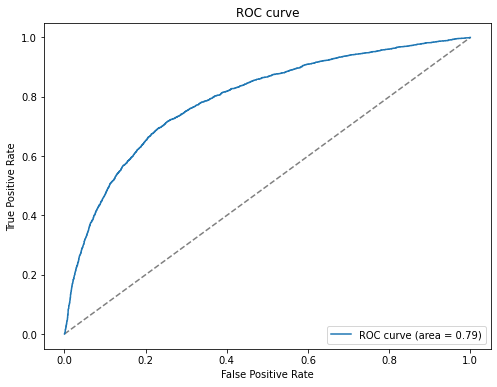

In [40]:
plot_roc_curve(LR, X_test, y_test)

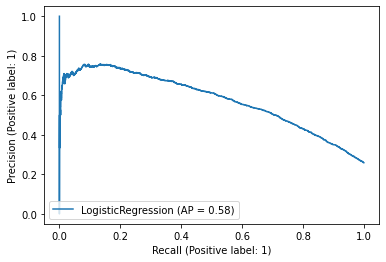

In [41]:
plot_precision_recall_curve(LR, X_test, y_test);

In [42]:
y_proba = LR.predict_proba(X_test)
y_proba

array([[0.86479144, 0.13520856],
       [0.58144912, 0.41855088],
       [0.90705864, 0.09294136],
       ...,
       [0.07807052, 0.92192948],
       [0.7363012 , 0.2636988 ],
       [0.67576853, 0.32423147]])

In [43]:
y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [44]:
y_test

51294    0
25822    0
20706    0
23232    1
24115    0
        ..
8066     0
15213    0
24293    1
51235    0
51514    0
Name: Monitoring Status, Length: 11045, dtype: int64

### KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
# Don´t do this!!!

skf = StratifiedKFold(n_splits=5)
knn = GridSearchCV(KNeighborsClassifier(),
                      param_grid = {'n_neighbors':np.arange(3,17,2)},
                      scoring = 'recall', cv = skf)

knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15])},
             scoring='recall')

In [47]:
knn.best_params_

{'n_neighbors': 3}

In [48]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [49]:
y_pred = knn.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      8187
           1       0.61      0.47      0.53      2858

    accuracy                           0.78     11045
   macro avg       0.72      0.68      0.70     11045
weighted avg       0.77      0.78      0.78     11045



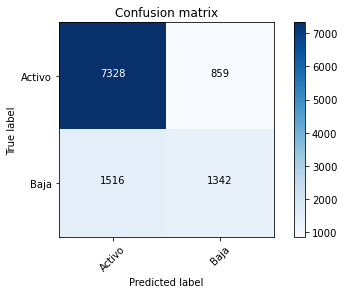

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test,y_pred))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.74


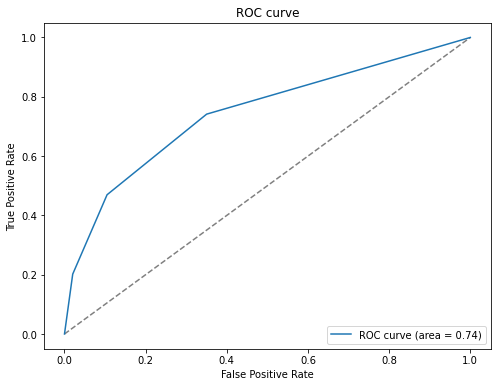

In [51]:
plot_roc_curve(knn, X_test, y_test)

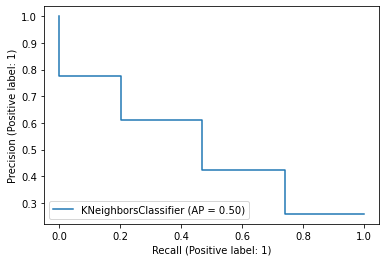

In [52]:
plot_precision_recall_curve(knn, X_test, y_test);

### Decission Tree Classifier

Decision Tree Accuracy is 0.74
Cross Validation Score = 0.75
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      8187
           1       0.49      0.71      0.58      2858

    accuracy                           0.74     11045
   macro avg       0.69      0.73      0.70     11045
weighted avg       0.78      0.74      0.75     11045



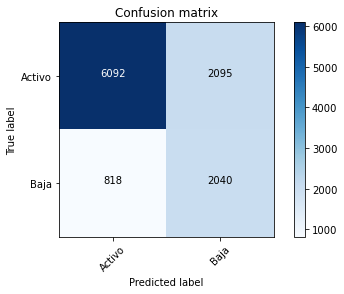

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

DT = DecisionTreeClassifier(random_state = 0,class_weight="balanced", min_weight_fraction_leaf=0.01)
DT = DT.fit(X_train,y_train)
print ("Decision Tree Accuracy is %2.2f" % accuracy_score(y_test, DT.predict(X_test)))

skf = StratifiedKFold(n_splits=5)
score_DT = cross_val_score(DT, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_DT)

y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.80


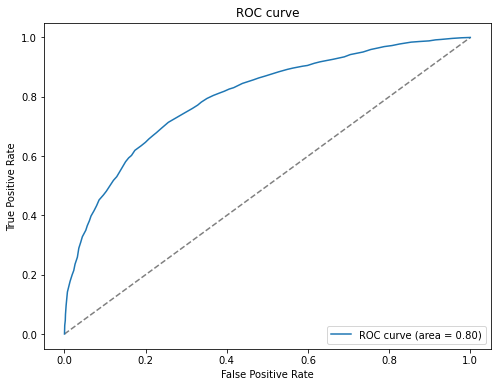

In [54]:
plot_roc_curve(DT, X_test, y_test)

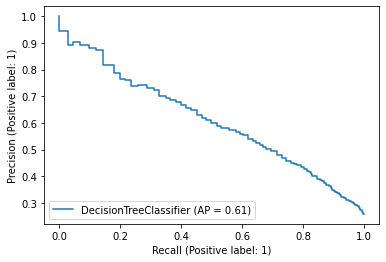

In [55]:
plot_precision_recall_curve(DT, X_test, y_test);

In [56]:
DT.predict_proba(X_test)

array([[0.97476826, 0.02523174],
       [0.56732736, 0.43267264],
       [0.87866671, 0.12133329],
       ...,
       [0.01742549, 0.98257451],
       [0.79211191, 0.20788809],
       [0.77882252, 0.22117748]])

In [57]:
LR.predict_proba(X_test)

array([[0.86479144, 0.13520856],
       [0.58144912, 0.41855088],
       [0.90705864, 0.09294136],
       ...,
       [0.07807052, 0.92192948],
       [0.7363012 , 0.2636988 ],
       [0.67576853, 0.32423147]])

In [58]:
y_test

51294    0
25822    0
20706    0
23232    1
24115    0
        ..
8066     0
15213    0
24293    1
51235    0
51514    0
Name: Monitoring Status, Length: 11045, dtype: int64

### Random Forest Classifier

Random Forest Accuracy is 0.81
Cross Validation Score = 0.82
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      8187
           1       0.65      0.61      0.63      2858

    accuracy                           0.81     11045
   macro avg       0.76      0.75      0.75     11045
weighted avg       0.81      0.81      0.81     11045



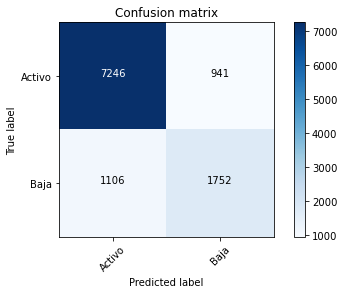

In [59]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=10,class_weight="balanced")
rfc.fit(X_train, y_train)
print ("Random Forest Accuracy is %2.2f" % accuracy_score(y_test, rfc.predict(X_test)))

skf = StratifiedKFold(n_splits=20)
score_rfc = cross_val_score(rfc, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_rfc)

y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred ))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.84


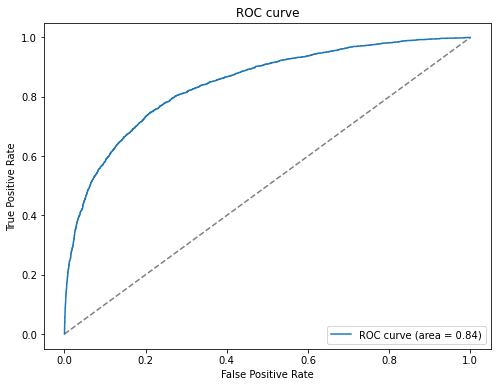

In [60]:
plot_roc_curve(rfc, X_test, y_test)

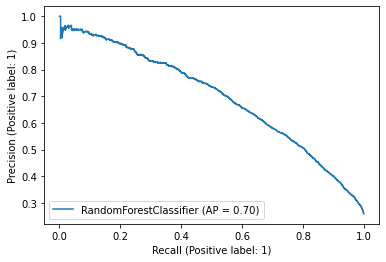

In [61]:
plot_precision_recall_curve(rfc, X_test, y_test);

In [62]:
rfc.predict_proba(X_test)

array([[0.96556285, 0.03443715],
       [0.53575391, 0.46424609],
       [0.86367683, 0.13632317],
       ...,
       [0.28985615, 0.71014385],
       [0.8883568 , 0.1116432 ],
       [0.85527715, 0.14472285]])

### XGBoost

GradientBoost Accuracy= 0.83
Cross Validation Score = 0.84
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      8187
           1       0.74      0.51      0.61      2858

    accuracy                           0.83     11045
   macro avg       0.80      0.73      0.75     11045
weighted avg       0.82      0.83      0.82     11045



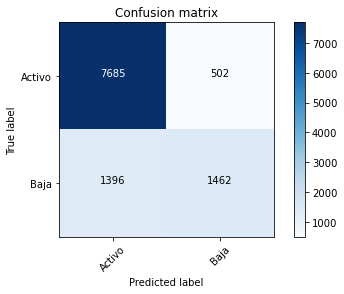

In [63]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, booster='gbtree', learning_rate=0.01, objective='binary:logistic')
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print ("GradientBoost Accuracy= %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5)
score_xgb = cross_val_score(xgb, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_xgb)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.86


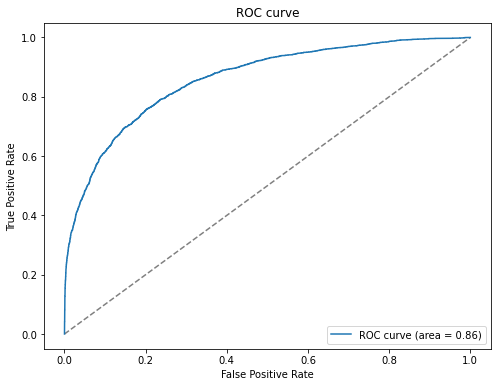

In [64]:
plot_roc_curve(xgb, X_test, y_test)

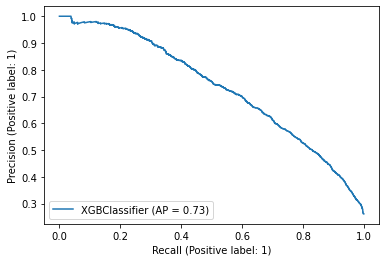

In [65]:
plot_precision_recall_curve(xgb, X_test, y_test);

### Comparing ROC Curves

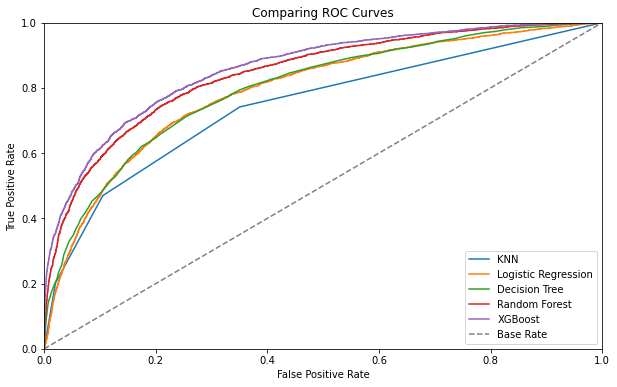

In [66]:
plt.figure(figsize = (10,6), linewidth= 1)

knn_fpr, knn_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
LR_fpr, LR_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test)[:,1])
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, DT.predict_proba(X_test)[:,1])
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])

plt.plot(knn_fpr, knn_tpr, label='KNN' )
plt.plot(LR_fpr, LR_tpr, label='Logistic Regression')
plt.plot(DT_fpr, DT_tpr, label='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest')
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost')

plt.plot([0,1],[0,1],label='Base Rate', ls = '--', c = 'grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Comparing ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Comparing PR Curves

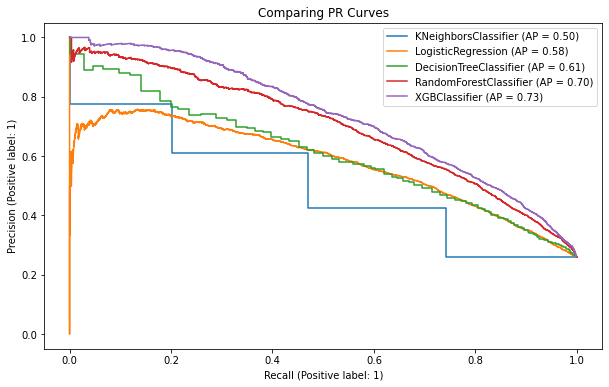

In [67]:
models = [knn, LR, DT, rfc, xgb]

fig, ax = plt.subplots(figsize=(10, 6))
for m in models:
    plot_precision_recall_curve(m, X_test, y_test, ax=ax)
    plt.legend(loc="upper right")
ax.set_title("Comparing PR Curves");

### Feature importances

In [68]:
from sklearn.feature_selection import RFE

# Using Recursive Feature Elimination Function and fitting it in a Logistic Regression Model
modell = LogisticRegression(max_iter=1000, class_weight="balanced")
rfe = RFE(modell, 5)
rfe = rfe.fit(X_train,y_train)

rfe.ranking_

C:\Users\alber\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([ 7,  6,  3,  8,  5,  1, 10,  4,  1,  2,  1, 11,  9,  1,  1])

In [69]:
result = zip(X_train.columns, rfe.ranking_)

result_set = set(result)
print(result_set)

{('Gender', 7), ('Provincia', 10), ('Tipo Instalacion', 3), ('Zip', 1), ('Number Pay', 11), ('Quejas_sca', 1), ('Nationality', 4), ('MT_sca', 1), ('Marital Status', 5), ('Rango Kit', 1), ('Labor Situation', 8), ('Income', 2), ('Dias_Activo_sca', 9), ('Rango_Edad', 1), ('Housing Type', 6)}


[0.02342789 0.03695339 0.09489859 0.0468672  0.03550755 0.12886763
 0.03714096 0.03941072 0.07051798 0.05980578 0.06051937 0.03827285
 0.15774098 0.07487641 0.09519269]


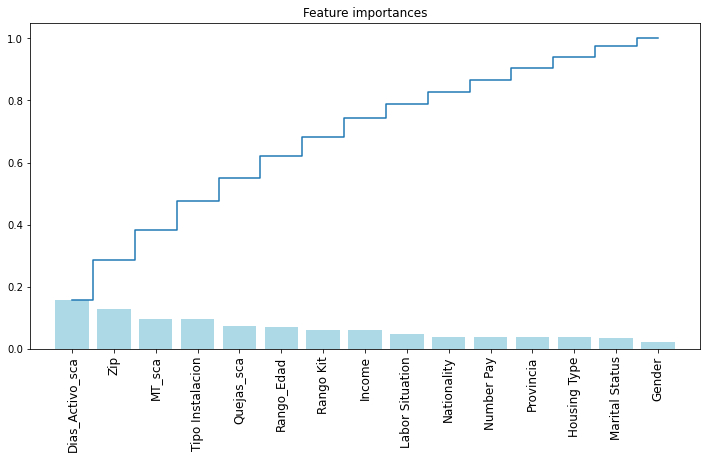

In [70]:
from sklearn.ensemble import ExtraTreesClassifier

# Using ExtraTreesClassifier model function
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

# Printing important features in the model
print(model.feature_importances_)
importances = model.feature_importances_
feat_names = data_filtered.drop(['Monitoring Status'],axis=1).columns

# Displaying the feature importances as a chart by sorting it in the order of importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=12)
plt.xlim([-1, len(indices)])
plt.show()